# 1. Imports and installs

In [1]:
!pip install -q pycocotools --quiet

In [224]:
#Standard libraries
import numpy as np
import pandas as pd
from pathlib import Path
import sys
import random
#Picture displaying
from matplotlib.patches import Polygon
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy.ndimage import zoom
#Model
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input, Conv2DTranspose, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
#Dataset
from pycocotools.coco import COCO

# 2. Dataset importation

In [3]:
#path to the annotations
annotations_path = Path('/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json')
#load the COCO api so we can work with the data
coco = COCO(annotations_path)
#num of categories in coco
#can be for normalisation of the filter
num_of_cat = 91

loading annotations into memory...
Done (t=29.19s)
creating index...
index created!


### Chosing random 100 cat and dog pictures

In [4]:
#we select random photos of cats and dogs and return their ids
def select_random_cat_and_dog_imgs():
    #get all pic ids with cats
    img_ids_cat = coco.getImgIds(catIds=coco.getCatIds(catNms=['cat']))
    #get all pic ids with dogs
    img_ids_dog = coco.getImgIds(catIds=coco.getCatIds(catNms=['dog']))

    #concatenate all of those ids
    img_ids_cat_dog = set(img_ids_cat) | set(img_ids_dog)

    #choose a random subset of the pictures
    subset_size = 100
    return random.sample(img_ids_cat_dog, min(subset_size, len(img_ids_cat_dog)))

In [5]:
selected_img_ids = select_random_cat_and_dog_imgs()

/tmp/ipykernel_47/3952498370.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  return random.sample(img_ids_cat_dog, min(subset_size, len(img_ids_cat_dog)))


# 3. Data analyzation

In [6]:
def show_picture(loaded_img):
    response = requests.get(loaded_img['coco_url'])
    image = Image.open(BytesIO(response.content))

    fig, ax = plt.subplots(1)

    ax.imshow(image)

    plt.show()

### Show us 5 random pictures with their segmentations

In [7]:
#shows one picture with all of its segmentations
#provide a loaded picture as the argument
def show_picture_and_segments(loaded_img):
    #get all the annotations for the image 
    annotations = coco.getAnnIds(loaded_img['id'])
    #so we can get all the segmentations here
    segmentations = [coco.anns[annotations[i]]['segmentation'] for i in range(len(annotations))]
    response = requests.get(loaded_img['coco_url'])
    image = Image.open(BytesIO(response.content))

    fig, ax = plt.subplots(1)

    ax.imshow(image)

    #this is where we add the segmentations for the picture
    for segmentation in segmentations:
        for poly in segmentation:
            xy = np.array(poly).reshape((len(poly) // 2, 2))
            polygon = Polygon(xy, edgecolor='r', fill=False)
            ax.add_patch(polygon)

    ax.axis('off')

    plt.show()

In [ ]:
def show_random_5_images(img_ids):
    amount_of_imgs = 5
    #random starting index for 5 photos
    batch_start = random.randint(0,len(img_ids)-amount_of_imgs)
    #load them up
    imgs = coco.loadImgs(img_ids[batch_start:batch_start+amount_of_imgs])
    
    for img in imgs:
        show_picture_and_segments(img)

In [ ]:
show_random_5_images(selected_img_ids)

### Sizes of pictures differ

Let's see what are the maximum widths and heights of pictures.

In [8]:
#load all selected images
all_imgs_loaded = coco.loadImgs(selected_img_ids)

In [9]:
#provide loaded imgs and this will give you 
#min, max width; min, max height respectively
def width_height_min_max(loaded_imgs):
    max_width = sys.maxsize*-1
    min_width = sys.maxsize
    max_height = sys.maxsize*-1
    min_height = sys.maxsize

    #go through all the pics and find max/min widths/heights
    for img in loaded_imgs:
        max_width = img['width'] if img['width'] > max_width else max_width
        min_width = img['width'] if img['width'] < min_width else min_width
        max_height = img['height'] if img['height'] > max_height else max_height
        min_height = img['height'] if img['height'] < min_height else min_height
        
    print('Minimal expected picture size is: {0}x{1}, and maximal expected picture size is: {2}x{3}'.format(min_width, min_height, max_width, max_height))
    return (min_width, max_width, min_height, max_height)

In [10]:
min_width, max_width, min_height, max_height = width_height_min_max(all_imgs_loaded)

Minimal expected picture size is: 308x233, and maximal expected picture size is: 640x640


We see that the pictures are of different sizes, we need to make them somehow equal so we can feed it to the model.<br>
The idea I suggest is filling the smaller pictures with 0's so they meet the size of bigger pictures.<br>

### The number of segmentations and their sizes differ as well

In [ ]:
first_pic_segmentation_ids = coco.getAnnIds(all_imgs_loaded[0]['id'])
print('The segmentation ids in the first picture are: {0}'.format(first_pic_segmentation_ids))

In [ ]:
second_pic_segmentation_ids = coco.getAnnIds(all_imgs_loaded[1]['id'])
print('and in the second one: {0}'.format(second_pic_segmentation_ids))

When we take a look above we see that the number of class segments for each of the pictures is different.<br>
The numbers represent ids for their segmentations. This tells us that pictures have different amounts of segments in them.<br>
Let's look a bit further.

In [ ]:
first_pic_segmentation_data_points = coco.anns[first_pic_segmentation_ids[0]]['segmentation']
print('The segmentation data points for the first picture are: {0}'.format(first_pic_segmentation_data_points))

In [ ]:
second_pic_segmentation_data_points = coco.anns[second_pic_segmentation_ids[0]]['segmentation']
print('and for the second picture they are: {0}'.format(second_pic_segmentation_data_points))

It is noticable that the pictures have different amounts of datapoints for their segments.<br>
Again we're gonna have to take care of that, we're going to make masks for the segmentations.<br>
The idea is (since were doing segmentation for dogs and cats) to one hot encode a pixel so that<br>
one pixel in the picture is given with the 3 numbers where the number can be 1 or 0 indicating that<br>
it belongs to the class on that position or it doesn't respectively (pos. 0-nothing, pos. 1-cat, pos. 2-dog).<br>
For example:<br>
[1,0,0]-nothing<br>
[0,1,0]-cat<br>
[0,0,1]-dog

### Class imbalance

If we take a look at the pictures we will notice that more pixels belong to the class nothing than to the class cat or dog.<br>
This is going to make problems for us doing training as the model is going to predict the class nothing over the other two<br>
very often.<br>
To fix this we will calculate the ratio of the classes and introduce the weighted loss function to make the model pay attention<br>
more to the classes of cats and dogs.

# 4. Data preprocessing

In [225]:
#These values will be used for the size of the preprocessed data
#and input size for the model
desired_width = 224
desired_height = 224
#3 RGB(False) layers or 1(True)
grayscale = False

#dont change this part/ it will adjust itself
desired_layers = 3
if grayscale:
    desired_layers = 1

In [226]:
#this function will load up all the images we select and scale them, remove colors ecc..
#based on the settings
#it will also make coresponding masks which we will use for labels (the thing the model will learn)
#provide loaded images via the coco.loadImgs() function
def preprocess_features_and_labels(loaded_imgs, max_width=640, max_height=640, desired_output_width=64, desired_output_height=64, scale=False, zero_pad=False, grayscale=True):
    #request all the images based on their url
    responses = [requests.get(loaded_img['coco_url']) for loaded_img in loaded_imgs]
    #open all the images
    imgs = [Image.open(BytesIO(response.content)).resize((desired_output_width, desired_output_height)) if scale else Image.open(BytesIO(response.content)) for response in responses]

    #LABELS PREPROCESSING
    #get the annotations for the images so we can get their segmentations
    annotations = [coco.loadAnns(coco.getAnnIds(img['id'])) for img in loaded_imgs]
    #get the segmentations for the images and make masks which we will use as labels
    #the filter will contain the category id where the certain category is present and 0's otherwise
    segmentation_masks = [[coco.annToMask(segmentation)*(segmentation['category_id'] % 16) if segmentation['category_id'] in [17,18] else np.zeros((coco.annToMask(segmentation).shape[0], coco.annToMask(segmentation).shape[1])) for segmentation in annotation] for annotation in annotations]        
    #we connect all the different masks into one mask
    segmentation_masks_merged = [np.maximum.reduce(masks) for masks in segmentation_masks]
    #resize the masks to match the pictures
    if scale:
        #we turned of the anti_aliasing property because we want the masks to be ints not floats or doubles
        #segmentation_masks_merged = [resize(mask, (desired_output_height, desired_output_width), anti_aliasing=False) for mask in segmentation_masks_merged]
        segmentation_masks_merged = [zoom(mask, (desired_output_height/len(mask), desired_output_width/len(mask[0])), order=0, mode='nearest') for mask in segmentation_masks_merged]
    

    #here comes the zero padding we were talking about earlier
    def zero_pad_img(img, zero_pad):
        image_to_be_processed = img
        
        if zero_pad:
            image_to_be_processed = np.zeros((max_width, max_height, 3))
            image_to_be_processed[:img.shape[0],:img.shape[1],:] = img
            
        return image_to_be_processed
    
    #zero pad the masks if the zero_pad is set to True
    def zero_pad_mask(mask, zero_pad):
        mask_to_be_processed = mask

        if zero_pad:
            mask_to_be_processed = np.zeros((max_width, max_height))
            mask_to_be_processed = np.maximum.reduce(np.array([mask, mask_to_be_processed]))
            
        return mask_to_be_processed
                       
    #transfer all the images into array forms and padd them with zeros
    #to fit the max_width and max_height
    imgs_array_form = [zero_pad_img(image.img_to_array(img)/255, zero_pad) for img in imgs] 
    segmentation_masks_merged = [zero_pad_mask(mask, zero_pad) for mask in segmentation_masks_merged] 
                 
    #if you want the picture without colors
    if grayscale:
        imgs_array_form = np.mean(imgs_array_form, axis=3, keepdims=True)

    #we turn the array Y into categorical array mentioned as before
    #so we can use categorical cross entropy on it
    return np.asarray(imgs_array_form), to_categorical(np.asarray(segmentation_masks_merged))

In [227]:
x, Y = preprocess_features_and_labels(all_imgs_loaded, max_width, max_height, desired_width, desired_height, scale=True, grayscale=grayscale)

The data for Y was normalized above and the data for x has already been normalized.

In [15]:
#this function shows us the original image and its segmentations
#as well as the preprocessed image and the preprocessed mask for it
#which we will give the model to learn
def show_preprocessed_image_and_mask(original_image, preprocessed_data):
    #preprocessed image
    img = preprocessed_data[0]
    #preprocessed mask for that image
    mask = preprocessed_data[1]
    
    #show the original image with original size
    show_picture(original_image)
    #show the original image with the segmentations
    show_picture_and_segments(original_image)
    
    #show the preprocessed image separately
    plt.title('The preprocessed image')
    plt.imshow(img, cmap='gray') 
    
    fig, ax = plt.subplots()
    
    #show the preprocessed mask separately
    plt.title('The preprocessed mask')
    ax.imshow(mask, alpha=0.3, extent=(0, mask.shape[1], mask.shape[0], 0))
    
    fig, ax = plt.subplots()
    
    #show the preprocessed mask and image together
    plt.title('The preprocessed mask on top of the preprocessed image')
    ax.imshow(img, cmap='gray')
    ax.imshow(mask, alpha=0.3, extent=(0, mask.shape[1], mask.shape[0], 0))

    plt.show()

In [ ]:
show_preprocessed_image_and_mask(all_imgs_loaded[0], (x[0], Y[0]))

Now after all of that data processing we have a preprocessed pictures and a preprocessed masks which we will try to teach the model.<br>
We do this because the model should be able to learn the correlations of the mask and the picture better with this spatial features.<br>
This is the better method I was talking about. First i wanted to teach the model the datapoints of the segmentations or the line that<br>
runs around objects in the picture, but then I realised it would be a lot better if I made masks which the model could learn. This will<br>
also give us the opportunity to make a <b>Fully Convolutional Neural Network<b>.

## Dealing with class imbalance

In [124]:
def calculate_class_imbalance(Y):
    nothing_pixels = np.where(Y[:, :, :, 0] == 1)[2].shape[0]
    cat_pixels = np.where(Y[:, :, :, 1] == 1)[2].shape[0]
    dog_pixels = np.where(Y[:, :, :, 2] == 1)[2].shape[0]
    
    print('Number of pixels labeled as nothing is: {0}'.format(nothing_pixels))
    print('Number of pixels labeled as cat is: {0}{1}'.format(' ' * 4, cat_pixels))
    print('Number of pixels labeled as dog is: {0}{1}'.format(' ' * 4, dog_pixels))
    
    print("Nothing/cat+dog ratio is: {0}{1}".format(' ' * 14, nothing_pixels/(cat_pixels+dog_pixels)))
    print("Nothing/cat (cat weight) ratio is: {0}{1}".format(' ' * 5, nothing_pixels/cat_pixels))
    print("Nothing/dog (dog weight) ratio is: {0}{1}".format(' ' * 5, nothing_pixels/dog_pixels))
    
    #return weigths for nothing,cat,dog respectively
    return 1.0, nothing_pixels/cat_pixels, nothing_pixels/dog_pixels

In [127]:
weights = calculate_class_imbalance(Y)

Number of pixels labeled as nothing is: 2105965
Number of pixels labeled as cat is:     208257
Number of pixels labeled as dog is:     245778
Nothing/cat+dog ratio is:               4.638331846663803
Nothing/cat (cat weight) ratio is:      10.112337160335548
Nothing/dog (dog weight) ratio is:      8.568565941622115


## Train/validation data split

In [16]:
def train_val_split(x, Y, split_rate=0.2):
    train_x = x[:round(len(x)*(1-split_rate))]
    val_x = x[round(len(x)*(1-split_rate)):]
    train_Y = Y[:round(len(Y)*(1-split_rate))]
    val_Y = Y[round(len(Y)*(1-split_rate)):]
    
    return train_x, train_Y, val_x, val_Y

In [228]:
train_x, train_Y, val_x, val_Y = train_val_split(x, Y)

In [ ]:
print('Shape of train_x before: {0}'.format(train_x.shape))
print('Shape of train_Y before: {0}\n'.format(train_Y.shape))
print('Shape of val_x before: {0}'.format(val_x.shape))
print('Shape of val_Y before: {0}\n'.format(val_Y.shape))

As mentioned before in data analyzation we're going to calculate class imbalance and use it to introduce the weighted loss function.

# 5. The Model

## Parsenet approach

In [146]:
def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32)
    
    def loss(y_true, y_pred):
        # Apply weights to each class
        weighted_losses = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, pos_weight=weights)
        return tf.reduce_mean(weighted_losses)
    
    return loss

In [148]:
def conv_block(x, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    x = Conv2D(filters, kernel_size, padding=padding, activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, padding=padding, activation=activation)(x)
    x = BatchNormalization()(x)
    return x

def build_parsenet(weights, input_shape=(desired_width, desired_height, desired_layers)):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = conv_block(inputs, 16)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 32)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 64)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv_block(pool3, 128)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Decoder
    up5 = Concatenate()([UpSampling2D(size=(2, 2))(pool4), conv4])
    up6 = Concatenate()([UpSampling2D(size=(2, 2))(up5), conv3])
    conv6 = conv_block(up6, 128)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv2])
    conv7 = conv_block(up7, 64)
    
    up8 = Concatenate()([UpSampling2D(size=(2, 2))(conv7), conv1])
    conv8 = conv_block(up8, 32)
    
    # Output
    output = Conv2D(3, (1, 1), activation='softmax')(conv8)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    optimizer = tf.keras.optimizers.Adam(lr=0.001)
    model.compile(loss=weighted_categorical_crossentropy(weights), optimizer=optimizer, metrics=['accuracy', 'MeanSquaredError'])

    return model


In [ ]:
model = build_parsenet((1,1,1))
model.summary()

## Pretrained U-Net with transfer learning

In [245]:
 def build_unet():
    #we load the pretrained U-Net model first
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

    #freeze the layers of the pretrained so we don't change them
    for layer in base_model.layers:
        layer.trainable = False

    # Use encoder layers for feature extraction
    encoder_output = base_model.get_layer('block_13_expand_relu').output

    # Decoder
    x = UpSampling2D(size=(2, 2))(encoder_output)
    x = Concatenate()([x, base_model.get_layer('block_6_expand_relu').output])
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Concatenate()([x, base_model.get_layer('block_3_expand_relu').output])
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Concatenate()([x, base_model.get_layer('block_1_expand_relu').output])
    x = UpSampling2D(size=(2, 2))(x)
    outputs = Conv2D(3, (1, 1), activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [246]:
model = build_unet()
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_20[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']     

## Training

In [247]:
def train(model, train_x, train_Y, val_x, val_Y, epochs=5, batch_size=50):
    
    checkpoint = ModelCheckpoint(
            '',
            monitor='val_loss',
            verbose=1,
            save_best_only=True,
            mode='min'
    )

    history = model.fit(
        x=train_x,
        y=train_Y,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(val_x, val_Y)
    )
    
    return history

In [262]:
history = train(model, train_x, train_Y, val_x, val_Y,)

Epoch 1/5
2/2 [==============================] - 14s 5s/step - loss: 0.2538 - accuracy: 0.8259 - val_loss: 0.2158 - val_accuracy: 0.8482
Epoch 2/5
2/2 [==============================] - 12s 5s/step - loss: 0.2476 - accuracy: 0.8259 - val_loss: 0.2054 - val_accuracy: 0.8564
Epoch 3/5
2/2 [==============================] - 13s 5s/step - loss: 0.2362 - accuracy: 0.8353 - val_loss: 0.2001 - val_accuracy: 0.8650
Epoch 4/5
2/2 [==============================] - 13s 5s/step - loss: 0.2283 - accuracy: 0.8473 - val_loss: 0.1981 - val_accuracy: 0.8624
Epoch 5/5
2/2 [==============================] - 12s 5s/step - loss: 0.2245 - accuracy: 0.8492 - val_loss: 0.1943 - val_accuracy: 0.8685


# 6. Results

In [24]:
def plot_model_metrics(history):
    plt.title("Results")
    plt.plot(history.history['val_loss'], label="Val_loss")
    plt.plot(history.history['loss'], label="Loss")
    plt.legend()
    plt.show()

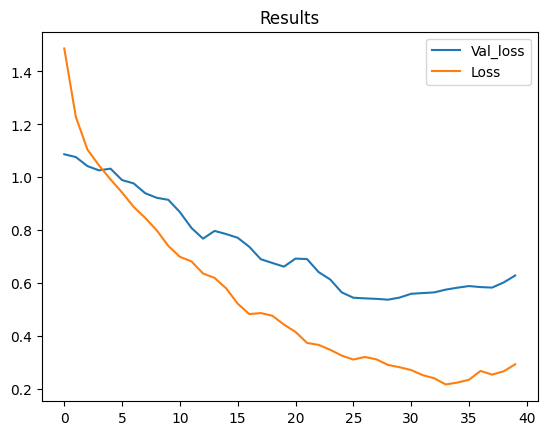

In [25]:
plot_model_metrics(history)

## The actual image

In [43]:
np.where((Y[4][:, :, 0] == 0))

(array([ 28,  28,  28, ..., 134, 134, 134]),
 array([115, 116, 117, ...,  66,  67,  68]))

In [253]:
indx_for_results = 4

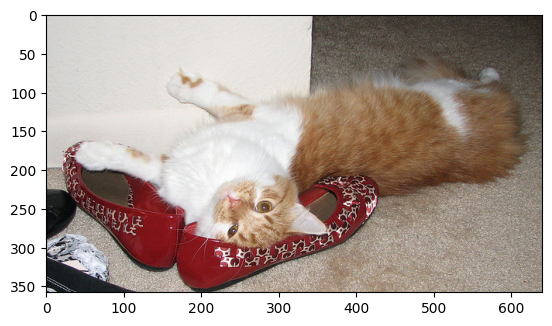

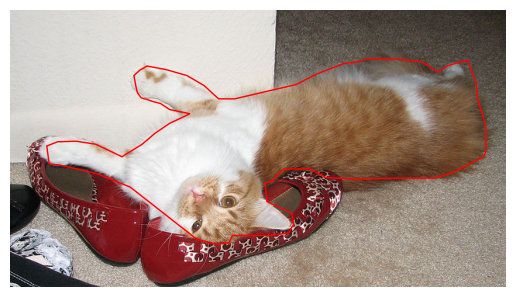

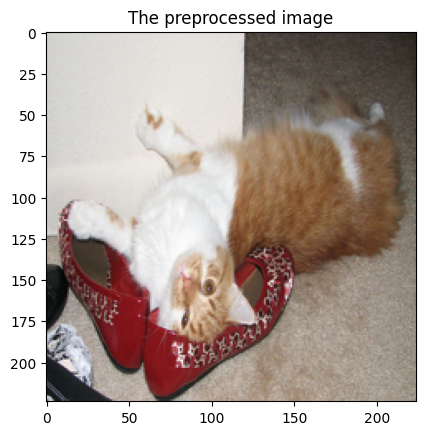

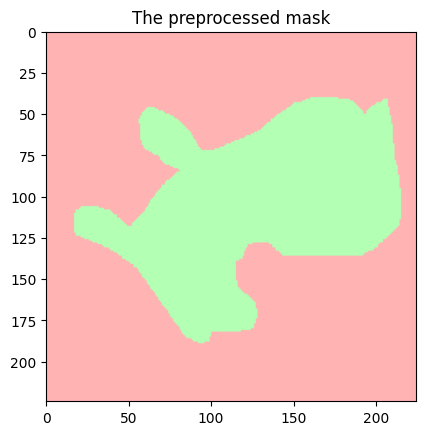

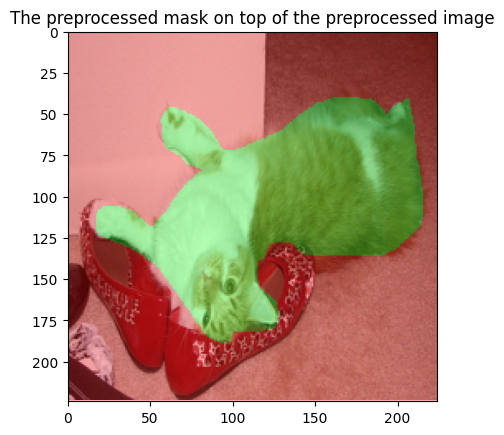

In [254]:
show_preprocessed_image_and_mask(all_imgs_loaded[indx_for_results], (x[indx_for_results], Y[indx_for_results]))

## What the model learned

In [263]:
prediction = model.predict(np.array([train_x[indx_for_results]]))[0]

1/1 [==============================] - 0s 83ms/step


In [ ]:
prediction

In [264]:
z = (np.argmax(prediction, axis=2)).astype(int)

In [75]:
np.any(np.argmax(z, axis=1)>0)

True

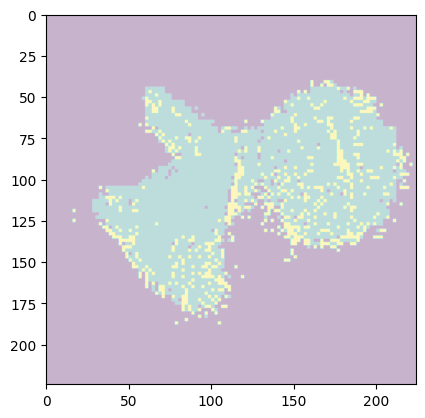

In [265]:
fig, ax = plt.subplots()
ax.imshow(z, alpha=0.3, extent=(0, z.shape[1], z.shape[0], 0))

In [62]:
def model_prediction_visualization(img_index_in_train):
    img = train_x[img_index_in_train]
    prediction = model.predict(np.array([train_x[img_index_in_train]]))[0]
    #take the maximum class probability for pixels
    prediction = (np.argmax(prediction, axis=2)).astype(int)
    
    fig, ax = plt.subplots()
    
    #show the preprocessed mask and image together
    plt.title('The original image, and model mask prediction above it')
    ax.imshow(img, cmap='gray')
    ax.imshow(prediction, alpha=0.3, extent=(0, prediction.shape[1], prediction.shape[0], 0))
    
    fig, ax = plt.subplots()
    plt.title('The learned mask')
    ax.imshow(prediction, alpha=0.3, extent=(0, prediction.shape[1], prediction.shape[0], 0))

    plt.show()

1/1 [==============================] - 0s 114ms/step


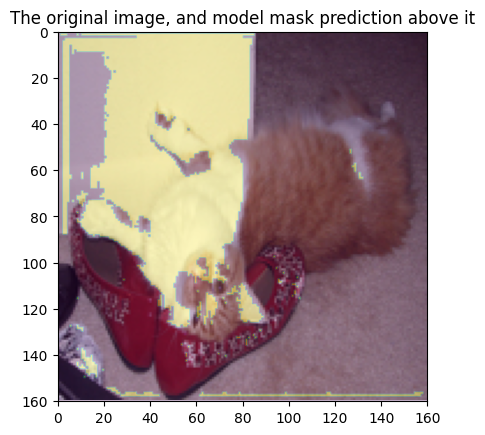

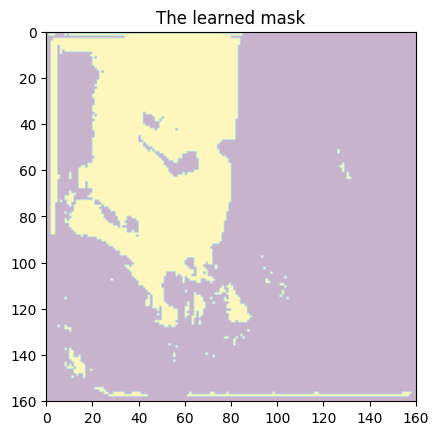

In [63]:
model_prediction_visualization(indx_for_results)